In [1]:
%matplotlib notebook

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Py3BR import threebodies, simulate, analysis, plotters
from inputs import input_dict

# Running one trajectory
Initialize the trajectory object by passing the input dictionary to the `TBR` class. Afterwards, use `runT()` to run the trajectory. 

In [3]:
traj = threebodies.TBR(**input_dict)
traj.runT()

# Plotting the trajectory
To plot the trajectory, use the `plotters.traj_plt()` tool. This can be a 2-d or 3-d plot. 

<IPython.core.display.Javascript object>


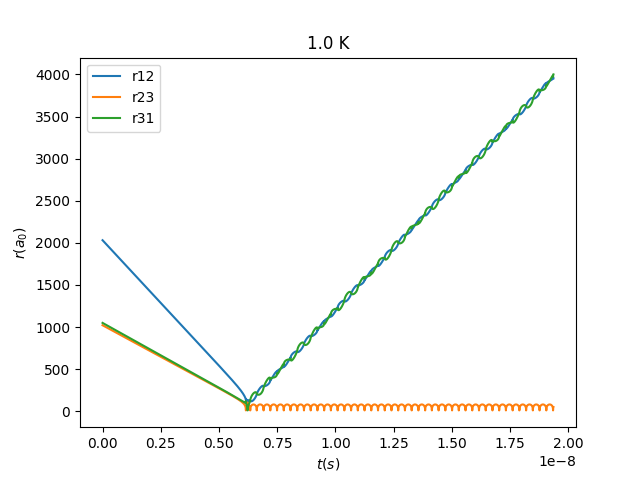

In [58]:
fig, ax = plt.subplots()
plotters.traj_plt(traj, ax)
plt.show()

<IPython.core.display.Javascript object>


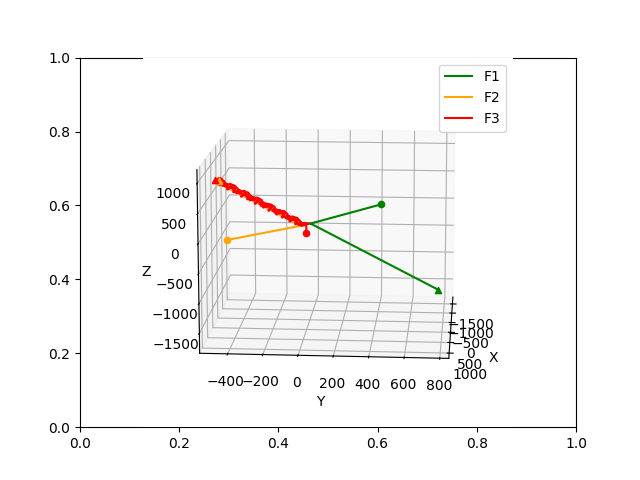

In [61]:
plt.figure()
plotters.traj_3d(traj)
plt.show()

# Sample TBR study of $Sr^+ + Cs + Cs$
To find the opacity function $P(E,b)$, run many trajectories over a range of impact parameters `b` for a given collision energy `E`. The `simulate` module offers parallel or serial computation. The range of `b` should be large enough that $P(E,b)$ reaches close to 0. 

In [6]:
out = 'results/sample.txt' # Output file for analysis
bi = np.arange(0,500,50) # Range of impact parameters
results = []
for b in bi:
    input_dict['b0'] = b
    long,short = simulate.runN(100, input_dict, short_out = out)
    results.append(short)

In [10]:
counts = pd.concat(results)

In [63]:
opac = analysis.opacity(out).reset_index(level=1)
sigma = analysis.cross_section(out).reset_index(0)
rate = analysis.k3(out,traj.mu0).reset_index(0)

<IPython.core.display.Javascript object>


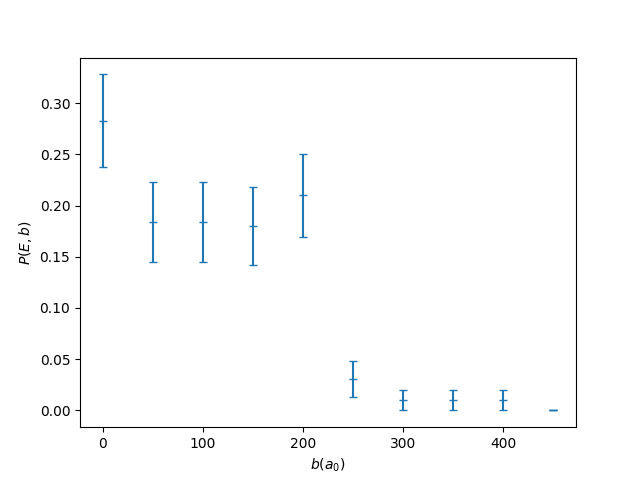

Text(0, 0.5, '$P(E,b)$')

In [65]:
# Plot opacity
plt.figure()
plt.errorbar(opac['b'], opac['pAB'], opac['pAB_err'], capsize = 3,fmt = '_')
plt.xlabel(r'$b (a_0)$')
plt.ylabel(r'$P(E,b)$')

In [66]:
rate

,e,k3_AB,k3_AB_err,k3_BB,k3_BB_err
0,1.0,9.164735e-27,5.594088e-27,0.0,0.0


# Full Study of $Sr^+ + Cs + Cs$
From the opacity function plot, large errorbars suggest that more trajectories are needed per impact parameter. The large deviations in $P(E,b)$ suggest a more dense grid of impact parameters should be used. For the same energy (E = 1K), we did 3000 trajectories per impact parameter, with an impact parameter spacing of 25. 

In [70]:
opac_f = pd.read_csv('results/opacity.txt', header=None).T # Transpose to rows
opac_f, opac_f.columns = opac_f[1:] , opac_f.iloc[0] # Turn labels to header

<IPython.core.display.Javascript object>


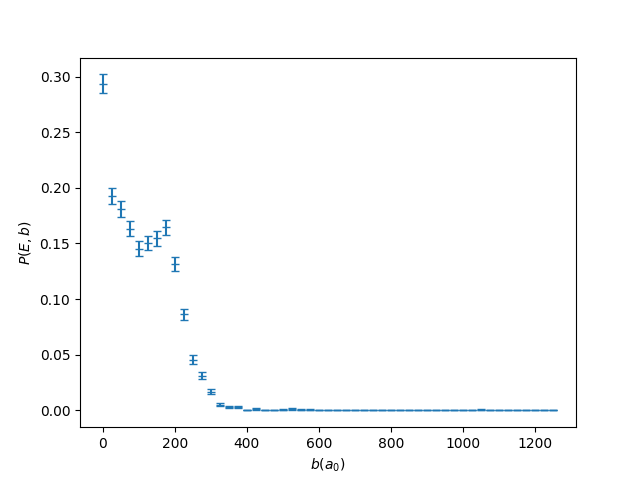

Text(0, 0.5, '$P(E,b)$')

In [71]:
# Look at E = 1K
opac_1 = opac_f[opac_f['e'] == 1].copy()
plt.figure()
plt.errorbar(opac_1['b'], opac_1['pAB'], opac_1['pAB_err'], capsize=3, fmt='_')
plt.xlabel(r'$b (a_0)$')
plt.ylabel(r'$P(E,b)$')

After running trajectories at different collision energies with appropriate impact parameter ranges, we can create a full three-body recombination rate plot.

In [72]:
rate_f = pd.read_csv('results/k3.txt')

<IPython.core.display.Javascript object>


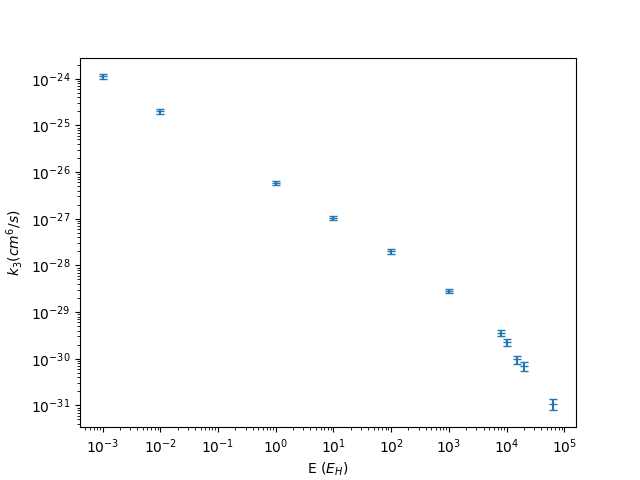

Text(0, 0.5, '$k_3 (cm^6/s)$')

In [73]:
plt.figure()
plt.errorbar(rate_f['e'], rate_f['k3_AB'], rate_f['k3_AB_err'], capsize=3, fmt='_')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'E ($E_H$)')
plt.ylabel(r'$k_3 (cm^6/s)$')